## CNN to classify Cat and Dog

# Outline

* The objective is to train a CNN model able to predict if  image is a cat or a dog.
* Create a custom dataset class
* Create a model
* Train and Test the model

# Data contains
* The data contains dog and cat images


# To perform well, we need to incorporate some prior knowledge about the problem

## In Deep Learning

* Many layers: compositionality
* Convolutions: locality + stationarity of images
* Pooling: Invariance of object class to translations

## Let's start by import some libraries

In [1]:
from plot_lib import plot_data, plot_model, set_default#

In [2]:
set_default()

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms,models
from torch.utils.data.sampler import SubsetRandomSampler
from torchvision.datasets import ImageFolder
from torch.optim import lr_scheduler
from pathlib import Path
import matplotlib.pyplot as plt
import numpy
import pandas as pd
from matplotlib.image import imread
import os
import glob
import os.path as osp
from PIL import Image
import torchvision
from torch.utils.data import Dataset, DataLoader, ConcatDataset
import torchvision.transforms as transforms
from torch.utils import data as D


# function to count number of parameters
def get_n_params(model):
    np=0
    for p in list(model.parameters()):
        np += p.nelement()
    return np

## Define data customes

In [4]:
class CatDogDataset(Dataset):
    def __init__(self, path, transform=None):
        self.classes   = os.listdir(path)
        self.path      = [f"{path}/{className}" for className in self.classes]
        self.file_list = [glob.glob(f"{x}/*") for x in self.path]
        self.transform = transform
        
        files = []
        for i, className in enumerate(self.classes):
            for fileName in self.file_list[i]:
                files.append([i, className, fileName])
        self.file_list = files
        files = None
        
    def __len__(self):
        return len(self.file_list)

    def __getitem__(self, idx):
        fileName = self.file_list[idx][2]
        classCategory = self.file_list[idx][0]
        im = Image.open(fileName)
        if self.transform:
            im = self.transform(im)
        return im, classCategory

In [6]:
image_size = (224, 224)
image_row_size = image_size[0] * image_size[1]
mean = [0.485, 0.456, 0.406]
std  = [0.229, 0.224, 0.225]
transform = transforms.Compose([
                                transforms.Resize(image_size), 
                                transforms.ToTensor(), 
                                transforms.Normalize(mean, std)])
    


In [7]:
path    = './train'
data_train = CatDogDataset(path, transform=transform)


In [8]:
path1   = './test'
data_test = CatDogDataset(path1, transform=transform)


In [29]:
dataloader_train.dataset.classes

['cat', 'dog']

In [37]:
#print(dataloader_train.dataset.class_to_idx)
#print(test_data.class_to_idx)

### Show images in data_train and data_test

In [10]:
def imshow(source):
    plt.figure(figsize=(10,10))
    imt = (source.view(-1, image_size[0], image_size[0]))
    imt = imt.numpy().transpose([1,2,0])
    imt = (std * imt + mean).clip(0,1)
    plt.subplot(1,2,2)
    plt.imshow(imt)


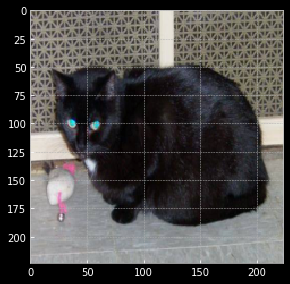

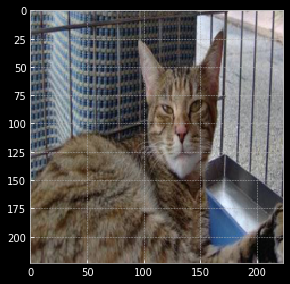

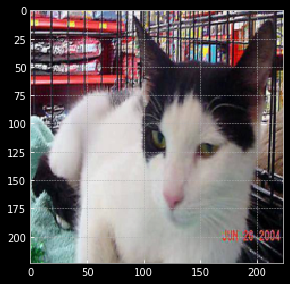

In [11]:
imshow(data_train[0][0])
imshow(data_train[2][0])
imshow(data_train[6000][0])

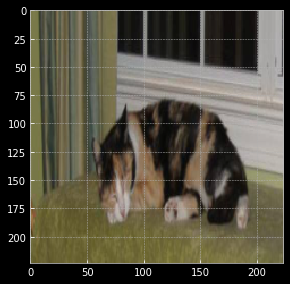

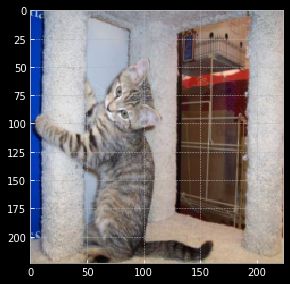

In [12]:
imshow(data_test[0][0])
imshow(data_test[2][0])

## Create DataLoader

* We will precise the batch_size, num_workers, and if the data will be shuffle or not.

In [13]:
shuffle     = True
batch_size  = 64
num_workers = 0

dataloader_train  = DataLoader(dataset=data_train, 
                         shuffle=shuffle, 
                         batch_size=batch_size, 
                         num_workers=num_workers)


dataloader_test  = DataLoader(dataset=data_test, 
                         shuffle=shuffle, 
                         batch_size=batch_size, 
                         num_workers=num_workers)

In [14]:
next(iter(data_train))

(tensor([[[ 0.4679,  0.1768,  0.2624,  ...,  0.1597,  0.2453,  0.4508],
          [ 0.5536,  0.6734,  0.5878,  ...,  0.1254,  0.1939,  0.3138],
          [ 0.5878, -0.0458, -0.3883,  ..., -0.8849, -0.6965,  0.0912],
          ...,
          [ 0.8104,  0.8789,  0.7419,  ...,  0.6049,  0.6734,  0.6563],
          [ 0.7933,  0.8104,  0.6563,  ...,  0.6392,  0.6734,  0.6563],
          [ 0.8618,  0.8447,  0.6734,  ...,  0.7419,  0.7077,  0.6734]],
 
         [[ 0.5028,  0.2052,  0.2577,  ...,  0.2227,  0.2752,  0.4853],
          [ 0.6078,  0.7129,  0.5903,  ...,  0.1877,  0.2402,  0.3627],
          [ 0.6429, -0.0049, -0.3725,  ..., -0.8452, -0.6527,  0.1352],
          ...,
          [ 0.9755,  1.0280,  0.9055,  ...,  0.7829,  0.8354,  0.8179],
          [ 0.9580,  0.9755,  0.8179,  ...,  0.8179,  0.8179,  0.8004],
          [ 1.0280,  1.0105,  0.8354,  ...,  0.9230,  0.8529,  0.8179]],
 
         [[ 0.4265,  0.2173,  0.4091,  ...,  0.2696,  0.3219,  0.5136],
          [ 0.4788,  0.6531,

### Let's check the size of the input (images) and the label




In [15]:
torchimage =iter( dataloader_train )             #create a iterator from a train_loader object
images, labels = torchimage.next() 
print(labels[0:])                                 # printt the label of the images in the batch
print(images.size())                              #print the size of the batch

tensor([1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0,
        1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1,
        0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0])
torch.Size([64, 3, 224, 224])


### Check classes

In [16]:
dataloader_train.dataset.classes

['cat', 'dog']

In [ ]:
print(train_data.class_to_idx)
print(test_data.class_to_idx)

In [17]:
dataloader_train .dataset.__getitem__(0)[0].size()  #check the size of the image

torch.Size([3, 224, 224])

###  Show some images after to transform

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


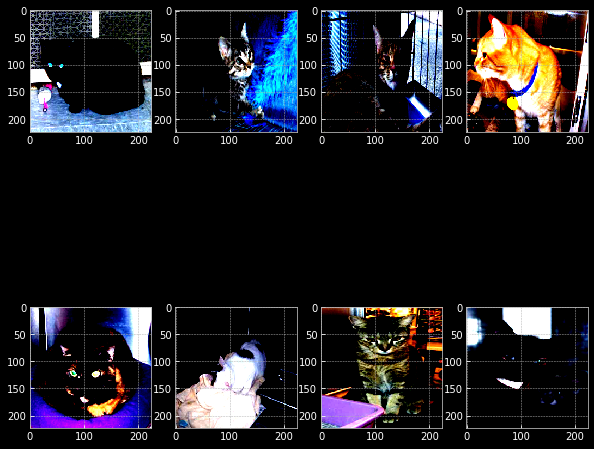

In [18]:

plt.figure()
for i in range(8):
    plt.subplot(2, 4, i + 1)
    image, _ = dataloader_train .dataset.__getitem__(i)
    plt.imshow(image.squeeze().numpy().transpose(1,2,0))

### A function to check the outpout shape and the filter size

In [68]:

import torch.nn as nn
n_feature = 3
check_archi = nn.Sequential(nn.Conv2d(in_channels=3, out_channels=32, kernel_size=5),
                            nn.MaxPool2d(2, 2),
                            nn.Conv2d(32, 64, kernel_size=5),
                            nn.MaxPool2d(2, 2),
                            nn.Conv2d(64, 128, kernel_size=5),
                            nn.MaxPool2d(2, 2),
                            nn.Conv2d(128,128, kernel_size=5),
                            nn.MaxPool2d(2, 2))

In [73]:
check_archi(torch.rand(1,3, 224,224)).shape[1]

128

In [70]:

filt, size = check_archi(torch.rand(20,3, 224, 224)).shape[1],\
        check_archi(torch.rand(20,3, 224, 224)).shape[2]
print(f'filter size {filt} and output shape {size}')

filter size 128 and output shape 10


# Create the model

* Define the FC2Layer (Fully Connected Layer)
* Define the CNN model(with 2 fully connected layer) where the output  is cat or dog

In [22]:
input_size  = 224*224*3   # images are 28x28 pixels
output_size = 2     # there are 2 classes

In [23]:
class FC2Layer(nn.Module):
    def __init__(self, input_size, n_hidden, output_size):
        super(FC2Layer, self).__init__()
        self.input_size = input_size
        self.network = nn.Sequential(
            nn.Linear(input_size, n_hidden), 
            nn.ReLU(), 
            nn.Linear(n_hidden, n_hidden), 
            nn.ReLU(), 
            nn.Linear(n_hidden, output_size), 
            nn.LogSoftmax(dim=1)
        ) 

    def forward(self, x):
        x = x.view(-1, self.input_size)
        return self.network(x)
    
class CNN_1(nn.Module):
    def __init__(self, input_size, n_feature, output_size):
        super(CNN_1, self).__init__()
        self.n_feature = n_feature
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=n_feature, kernel_size=5)
        self.conv2 = nn.Conv2d(n_feature, n_feature, kernel_size=5)
        self.fc1 = nn.Linear(n_feature*53*53, 50)
        self.fc2 = nn.Linear(50, 2)
        
    def forward(self, x, verbose=False):
        x = self.conv1(x)
        x = F.relu(x)
        x = F.max_pool2d(x, kernel_size=2)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, kernel_size=2)
        x = x.view(-1, self.n_feature*53*53) 
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.log_softmax(x, dim=1)
        return x

## Running on a GPU: device string

Switching between CPU and GPU in PyTorch is controlled via a device string, which will seemlessly determine whether GPU is available, falling back to CPU if not:

In [24]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

### Let's train our model

In [25]:
accuracy_list = []

def train(epoch, model, perm=torch.arange(0, 50176).long()):
    model.train()
    for batch_idx, (data, target) in enumerate(dataloader_train):
        

        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(dataloader_train.dataset),
                100. * batch_idx / len(dataloader_train), loss.item()))
            
def test(model, perm=torch.arange(0, 50176).long()):
    model.eval()
    test_loss = 0
    correct = 0
    for data, target in dataloader_test:
        # permute pixels
        data = data.view(-1, 224*224)
        data = data[:, perm]
        data = data.view(-1, 3, 224, 224)
        output = model(data)
        test_loss += F.nll_loss(output, target, reduction='sum').item() # sum up batch loss                                                               
        pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability                                                                 
        correct += pred.eq(target.data.view_as(pred)).cpu().sum().item()

    test_loss /= len(dataloader_test.dataset)
    accuracy = 100. * correct / len(dataloader_test.dataset)
    accuracy_list.append(accuracy)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(dataloader_train.dataset),
        accuracy))
    

# Train a small fully-connected network

In [26]:
n_hidden = 8 # number of hidden units

model_fnn = FC2Layer(input_size, n_hidden, output_size)
optimizer = optim.SGD(model_fnn.parameters(), lr=0.01, momentum=0.5)
print('Number of parameters: {}'.format(get_n_params(model_fnn)))

for epoch in range(0, 1):
    train(epoch, model_fnn)
    test(model_fnn)

Number of parameters: 1204322
Train Epoch: 0 [0/22500 (0%)]	Loss: 0.705085
Train Epoch: 0 [6400/22500 (28%)]	Loss: 0.660671
Train Epoch: 0 [12800/22500 (57%)]	Loss: 0.702693
Train Epoch: 0 [19200/22500 (85%)]	Loss: 0.680816

Test set: Average loss: 0.6447, Accuracy: 1567/22500 (63%)



# Train a ConvNet with the same number of parameters

In [27]:
# Training settings 
n_features = 6 # number of feature maps

model_CNN = CNN_1(input_size, n_features, output_size)
optimizer = optim.SGD(model_CNN.parameters(), lr=0.01, momentum=0.5)
print('Number of parameters: {}'.format(get_n_params(model_CNN)))

for epoch in range(0, 1):
    train(epoch, model_CNN)
    test(model_CNN)

Number of parameters: 844214
Train Epoch: 0 [0/22500 (0%)]	Loss: 0.692380
Train Epoch: 0 [6400/22500 (28%)]	Loss: 0.734009
Train Epoch: 0 [12800/22500 (57%)]	Loss: 0.630723
Train Epoch: 0 [19200/22500 (85%)]	Loss: 0.613964

Test set: Average loss: 0.6341, Accuracy: 1605/22500 (64%)



### So the ConvNet performs better with the same number of parameters, thanks to its use of prior knowledge about images







## We want Predict Dog or Cat with our Model

* Below, we write a function that takes an image path as input and predict  if it is a  dog or cat. 
* Don't forget that our target has 2 classes, 0: the cat and  1: Dog


In [38]:
#Import the image
path = 'index.jpeg'


In [39]:

def predict_transfer(img_path):
    # load the image and return the predict
    
    data_transform = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(), # randomly flip and rotate
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])
    
    img = data_transform(Image.open(img_path))

    
    img = img.unsqueeze(0)  # Insert the new axis at index 0 i.e. in front of the other axes/dims. 
    
    prediction = model_CNN(img)  # Returns a Tensor of shape (batch, num class labels)

    
    return prediction.data.cpu().numpy().argmax()

## Let see what is in the image

As we can see it's a cat, let see if the model will well predict

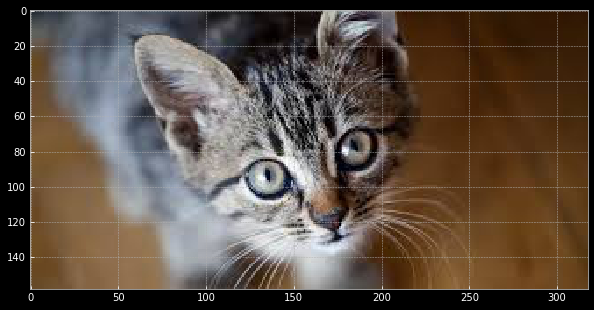

In [40]:
img = plt.imread('index.jpeg',0)
plt.gca().imshow(img) 

In [41]:
predict_transfer(path)

0

Whaou! It's work. It predict cat

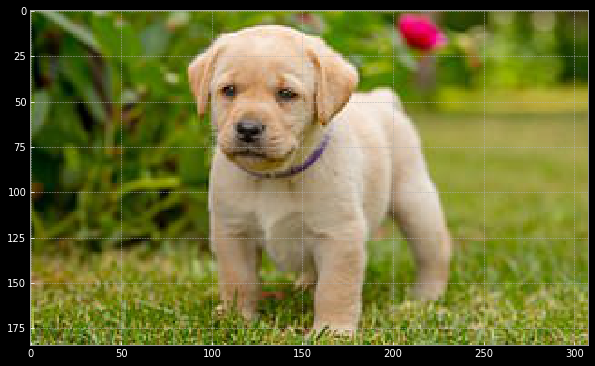

In [142]:
pic= 'Im2.jpg'
img = plt.imread('Im2.jpg',0)
plt.gca().imshow(img) 

In [143]:
predict_transfer(pic)

1

It's predict  a dog!

## As we can see, the model is able to predict, but it's not predict well and the accuracy is low. So we have to improve our model by adding many convolutional layer

###  Model CNN_2 with more convlutional layers

In [80]:
class CNN_2(nn.Module):
    def __init__(self, input_size, n_feature, output_size):
        super(CNN_2, self).__init__()
        self.n_feature = n_feature
        self.conv1 = nn.Conv2d(in_channels = 3, out_channels = 32, kernel_size=5)
        self.conv2 = nn.Conv2d(in_channels = 32, out_channels = 64, kernel_size=5)
        self.conv3 = nn.Conv2d(in_channels = 64, out_channels = 128, kernel_size=5)
        self.conv4 = nn.Conv2d(in_channels = 128, out_channels = 128, kernel_size=5)
        self.fc1 = nn.Linear(128*10*10, 50)
        self.fc2 = nn.Linear(50, 2)
        
    def forward(self, x, verbose=False):
        x = self.conv1(x)
        x = F.relu(x)
        x = F.max_pool2d(x, kernel_size=2)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, kernel_size=2)
        x = self.conv3(x)
        x = F.relu(x)
        x = F.max_pool2d(x, kernel_size=2)
        x = self.conv4(x)
        x = F.relu(x)
        x = F.max_pool2d(x, kernel_size=2)
        x = x.view(-1, 128*10*10) #(batch_size, -1) we can use also this
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.log_softmax(x, dim=1)
        return x

In [81]:
# Training settings 
n_features = 6 # number of feature maps

model_CNN = CNN_2(input_size, n_features, output_size)
optimizer = optim.SGD(model_CNN.parameters(), lr=0.01, momentum=0.5)
print('Number of parameters: {}'.format(get_n_params(model_CNN)))

for epoch in range(0, 1):
    train(epoch, model_CNN)
    test(model_CNN)

Number of parameters: 1308504
Train Epoch: 0 [0/22500 (0%)]	Loss: 0.693843
Train Epoch: 0 [6400/22500 (28%)]	Loss: 0.691732
Train Epoch: 0 [12800/22500 (57%)]	Loss: 0.671239
Train Epoch: 0 [19200/22500 (85%)]	Loss: 0.690712

Test set: Average loss: 0.6449, Accuracy: 1569/22500 (63%)

